# Card Spend and Software Attach Rate Analysis Plan

## Major Assumptions
We assume access to transaction data with card spend volumes, customer segmentation data (employee_count ranges and plan_tier categories), and software subscription records that can be linked at the company level. We'll define "software attach rate" as the percentage of companies within each segment that have at least one active software product subscription. Employee count will be bucketed into meaningful size categories (e.g., SMB, mid-market, enterprise).

## Plan
- [x] Data exploration and segment definition
  - [x] Examine distributions of employee_count and plan_tier to define customer segments
  - [x] Calculate total card spend volume aggregated by company
- [x] Compute software attach rates by segment
  - [x] Determine software subscription status per company and calculate attach rates across segment combinations
  - [x] Visualize attach rates as heatmap by employee size vs plan tier
- [x] Analyze spend-attach correlation
  - [x] Compare average spend volumes between software-attached vs non-attached customers within each segment
  - [x] Create visualizations showing spend distribution and attach rate relationship
- [x] Synthesize findings and identify high-opportunity segments
- [x] Analyze Net Revenue Retention and product expansion
  - [x] Track card count growth over time per customer to measure expansion velocity
  - [x] Examine product adoption patterns across bill pay, procurement, travel, expense modules
  - [x] Calculate multi-product adoption rates by segment

In [1]:
# Card Spend Volume and Software Attach Rate Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import os
import warnings
warnings.filterwarnings('ignore')

# SignalPilot dark theme
plt.rcParams.update({
    'figure.figsize': (10, 6), 'figure.dpi': 100, 'savefig.dpi': 300,
    'font.size': 11, 'axes.titlesize': 14, 'axes.labelsize': 12,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 10,
    'figure.titlesize': 16, 'axes.spines.top': False, 'axes.spines.right': False,
    'figure.facecolor': '#08070e', 'axes.facecolor': '#12101e',
    'axes.edgecolor': '#272336', 'axes.labelcolor': '#e9eaeb',
    'text.color': '#FAFAFA', 'xtick.color': '#a4a7ae', 'ytick.color': '#a4a7ae',
    'grid.color': '#1d182b', 'legend.facecolor': '#12101e',
    'legend.edgecolor': '#272336', 'legend.labelcolor': '#e9eaeb',
    'savefig.facecolor': '#08070e',
})

COLORS = {
    'primary': '#c4b5fd', 'secondary': '#ff8dc4', 'tertiary': '#8b5cf6',
    'blue': '#73acfb', 'red': '#c45757', 'yellow': '#fec163', 'green': '#4ca86f',
}
CATEGORICAL_PALETTE = ['#c4b5fd', '#ff8dc4', '#8b5cf6', '#73acfb', '#fec163', '#4ca86f']

# Connect to Ramp database
engine = create_engine(os.environ['RAMP_CONNECTION_URL'])

# Load all relevant tables
companies = pd.read_sql("SELECT * FROM companies", engine)
cards = pd.read_sql("SELECT * FROM cards", engine)
card_txns = pd.read_sql("SELECT * FROM card_txns", engine)
product_subs = pd.read_sql("SELECT * FROM product_subs", engine)

print(f"Companies: {len(companies):,} | Cards: {len(cards):,} | Transactions: {len(card_txns):,} | Subscriptions: {len(product_subs):,}")

Companies: 3,000 | Cards: 45,000 | Transactions: 350,000 | Subscriptions: 4,500


In [2]:
# Define customer segments and calculate card spend per company
# Segment by employee count: SMB (<50), Mid-Market (50-200), Enterprise (>200)
def assign_size_segment(emp_count):
    if emp_count < 50:
        return 'SMB'
    elif emp_count <= 200:
        return 'Mid-Market'
    else:
        return 'Enterprise'

companies['size_segment'] = companies['employee_count'].apply(assign_size_segment)

# Calculate total card spend per company (join cards -> card_txns)
card_spend = (
    card_txns[card_txns['status'] == 'settled']  # Only settled transactions
    .merge(cards[['id', 'company_id']], left_on='card_id', right_on='id', suffixes=('', '_card'))
    .groupby('company_id')['amount_usd']
    .sum()
    .reset_index()
    .rename(columns={'amount_usd': 'total_spend'})
)

# Identify companies with software attach (any active subscription)
software_attached = (
    product_subs[product_subs['status'] == 'active']
    .groupby('company_id')
    .size()
    .reset_index(name='active_subs')
)

# Build master company-level dataset
company_metrics = (
    companies
    .merge(card_spend, left_on='id', right_on='company_id', how='left')
    .merge(software_attached, left_on='id', right_on='company_id', how='left', suffixes=('', '_sub'))
)
company_metrics['total_spend'] = company_metrics['total_spend'].fillna(0)
company_metrics['active_subs'] = company_metrics['active_subs'].fillna(0)
company_metrics['has_software'] = company_metrics['active_subs'] > 0

print(f"Company metrics built: {len(company_metrics):,} companies")
print(f"\nSegment distribution:")
print(company_metrics['size_segment'].value_counts().sort_index())
print(f"\nPlan tier distribution:")
print(company_metrics['plan_tier'].value_counts())

Company metrics built: 3,000 companies

Segment distribution:
size_segment
Enterprise    1060
Mid-Market     491
SMB           1449
Name: count, dtype: int64

Plan tier distribution:
plan_tier
plus          1731
business       761
enterprise     270
free           238
Name: count, dtype: int64


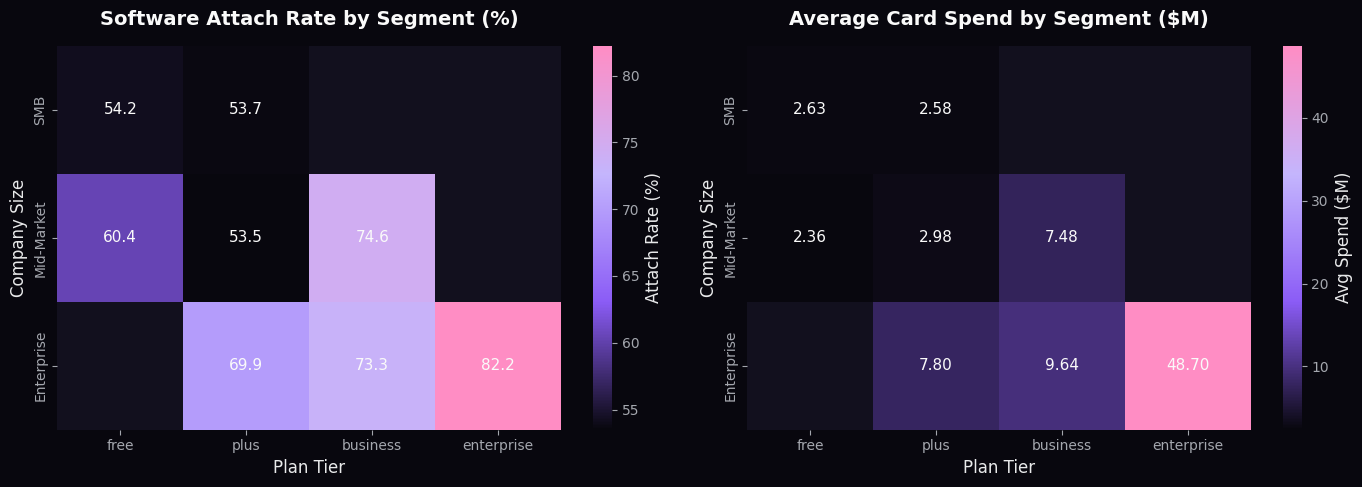

In [3]:
# Compute software attach rates by segment (size × plan tier)
segment_stats = (
    company_metrics
    .groupby(['size_segment', 'plan_tier'])
    .agg(
        total_companies=('id', 'count'),
        attached_companies=('has_software', 'sum'),
        total_spend=('total_spend', 'sum'),
        avg_spend=('total_spend', 'mean')
    )
    .reset_index()
)
segment_stats['attach_rate'] = segment_stats['attached_companies'] / segment_stats['total_companies'] * 100

# Create pivot tables for visualization
attach_pivot = segment_stats.pivot(index='size_segment', columns='plan_tier', values='attach_rate')
spend_pivot = segment_stats.pivot(index='size_segment', columns='plan_tier', values='avg_spend')

# Order segments logically
size_order = ['SMB', 'Mid-Market', 'Enterprise']
tier_order = ['free', 'plus', 'business', 'enterprise']
attach_pivot = attach_pivot.reindex(size_order)[tier_order]
spend_pivot = spend_pivot.reindex(size_order)[tier_order]

# Create side-by-side heatmaps
from matplotlib.colors import LinearSegmentedColormap
sp_cmap = LinearSegmentedColormap.from_list('signalpilot', ['#08070e', '#8b5cf6', '#c4b5fd', '#ff8dc4'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Attach rate heatmap
sns.heatmap(attach_pivot, annot=True, fmt='.1f', cmap=sp_cmap, ax=axes[0],
            cbar_kws={'label': 'Attach Rate (%)'}, annot_kws={'size': 11, 'color': '#FAFAFA'})
axes[0].set_title('Software Attach Rate by Segment (%)', fontweight='bold', pad=15)
axes[0].set_xlabel('Plan Tier')
axes[0].set_ylabel('Company Size')

# Average spend heatmap
sns.heatmap(spend_pivot / 1e6, annot=True, fmt='.2f', cmap=sp_cmap, ax=axes[1],
            cbar_kws={'label': 'Avg Spend (\$M)'}, annot_kws={'size': 11, 'color': '#FAFAFA'})
axes[1].set_title('Average Card Spend by Segment (\$M)', fontweight='bold', pad=15)
axes[1].set_xlabel('Plan Tier')
axes[1].set_ylabel('Company Size')

plt.tight_layout()
plt.show()

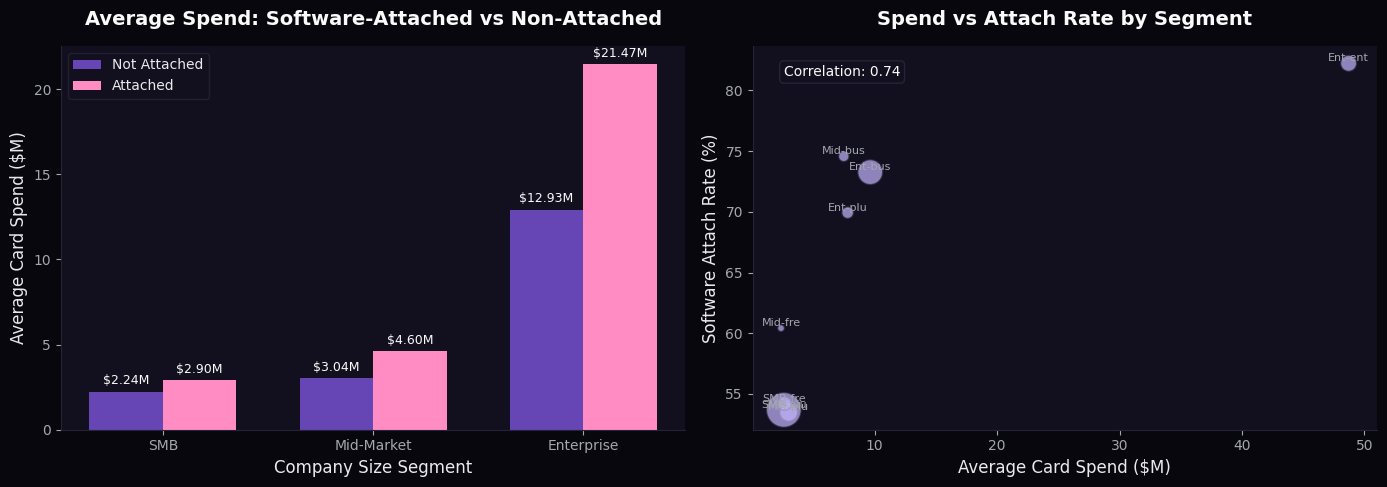


Spend Lift for Software-Attached Customers:
              Not Attached    Attached  Spend Lift
size_segment                                      
SMB              2237475.5   2899373.8        29.6
Mid-Market       3036971.7   4603293.8        51.6
Enterprise      12925241.3  21471700.9        66.1


In [4]:
# Analyze spend-attach correlation: compare attached vs non-attached within each segment
spend_comparison = (
    company_metrics[company_metrics['total_spend'] > 0]
    .groupby(['size_segment', 'has_software'])
    .agg(
        companies=('id', 'count'),
        avg_spend=('total_spend', 'mean'),
        median_spend=('total_spend', 'median'),
        total_spend=('total_spend', 'sum')
    )
    .reset_index()
)

# Calculate spend lift for attached customers
spend_lift = spend_comparison.pivot(index='size_segment', columns='has_software', values='avg_spend')
spend_lift.columns = ['Not Attached', 'Attached']
spend_lift = spend_lift.reindex(size_order)
spend_lift['Spend Lift'] = (spend_lift['Attached'] / spend_lift['Not Attached'] - 1) * 100

# Visualize: bar chart comparing avg spend by attach status
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of avg spend by segment and attach status
x = np.arange(len(size_order))
width = 0.35

not_attached_vals = [spend_lift.loc[s, 'Not Attached'] / 1e6 for s in size_order]
attached_vals = [spend_lift.loc[s, 'Attached'] / 1e6 for s in size_order]

bars1 = axes[0].bar(x - width/2, not_attached_vals, width, label='Not Attached', color=COLORS['tertiary'], alpha=0.7)
bars2 = axes[0].bar(x + width/2, attached_vals, width, label='Attached', color=COLORS['secondary'])

axes[0].set_xlabel('Company Size Segment')
axes[0].set_ylabel('Average Card Spend (\$M)')
axes[0].set_title('Average Spend: Software-Attached vs Non-Attached', fontweight='bold', pad=15)
axes[0].set_xticks(x)
axes[0].set_xticklabels(size_order)
axes[0].legend()

# Add value labels
for bar in bars1 + bars2:
    height = bar.get_height()
    axes[0].annotate(f'${height:.2f}M', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

# Scatter plot: spend vs attach rate correlation at segment level
segment_stats_filtered = segment_stats[segment_stats['total_companies'] >= 10].copy()
axes[1].scatter(segment_stats_filtered['avg_spend'] / 1e6, segment_stats_filtered['attach_rate'],
               s=segment_stats_filtered['total_companies'] * 0.5, c=COLORS['primary'], alpha=0.7, edgecolors='#272336')

# Add segment labels
for _, row in segment_stats_filtered.iterrows():
    axes[1].annotate(f"{row['size_segment'][:3]}-{row['plan_tier'][:3]}", 
                     (row['avg_spend']/1e6, row['attach_rate']),
                     fontsize=8, ha='center', va='bottom', color='#a4a7ae')

axes[1].set_xlabel('Average Card Spend (\$M)')
axes[1].set_ylabel('Software Attach Rate (%)')
axes[1].set_title('Spend vs Attach Rate by Segment', fontweight='bold', pad=15)

# Calculate correlation
corr = segment_stats_filtered['avg_spend'].corr(segment_stats_filtered['attach_rate'])
axes[1].text(0.05, 0.95, f'Correlation: {corr:.2f}', transform=axes[1].transAxes,
            fontsize=10, verticalalignment='top', color='#FAFAFA',
            bbox=dict(boxstyle='round', facecolor='#12101e', edgecolor='#272336'))

plt.tight_layout()
plt.show()

print(f"\nSpend Lift for Software-Attached Customers:")
print(spend_lift.round(1).to_string())

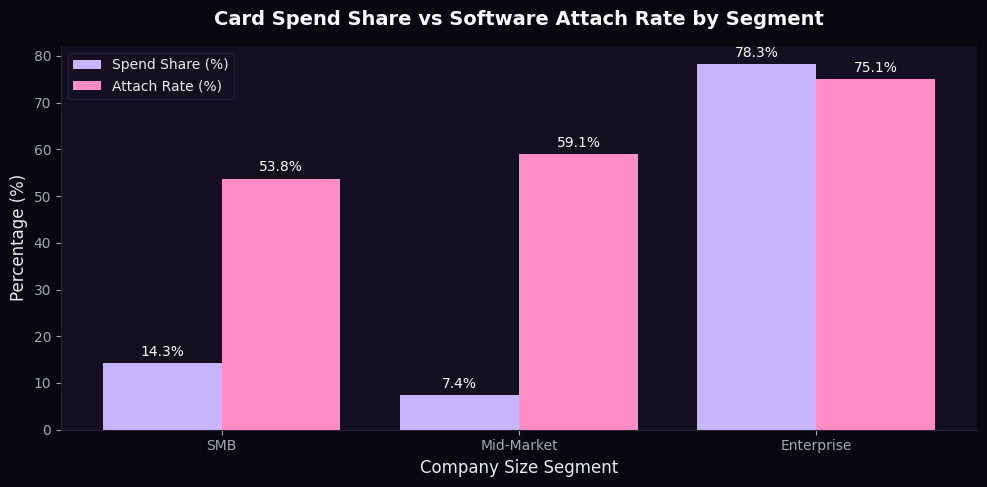

KEY FINDINGS: Card Spend & Software Attach Rate

📊 SPEND DISTRIBUTION:
  • SMB: $3.75B total (14.3% share)
  • Mid-Market: $1.95B total (7.4% share)
  • Enterprise: $20.50B total (78.3% share)

🔗 ATTACH RATE BY SEGMENT:
  • SMB: 53.8%
  • Mid-Market: 59.1%
  • Enterprise: 75.1%

💰 SPEND LIFT (Attached vs Non-Attached):
  • SMB: +29.6%
  • Mid-Market: +51.6%
  • Enterprise: +66.1%

📈 CORRELATION: 0.74 (higher spend segments have higher attach rates)


In [5]:
# Summary: Key metrics by segment
summary_df = (
    company_metrics
    .groupby('size_segment')
    .agg(
        companies=('id', 'count'),
        total_spend=('total_spend', 'sum'),
        avg_spend=('total_spend', 'mean'),
        attach_rate=('has_software', 'mean')
    )
    .reindex(size_order)
)
summary_df['attach_rate'] = summary_df['attach_rate'] * 100
summary_df['spend_share'] = summary_df['total_spend'] / summary_df['total_spend'].sum() * 100

# Create summary visualization
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(size_order))
width = 0.4

# Dual bars: spend share and attach rate
bars1 = ax.bar(x - width/2, summary_df['spend_share'], width, label='Spend Share (%)', color=COLORS['primary'])
bars2 = ax.bar(x + width/2, summary_df['attach_rate'], width, label='Attach Rate (%)', color=COLORS['secondary'])

ax.set_xlabel('Company Size Segment')
ax.set_ylabel('Percentage (%)')
ax.set_title('Card Spend Share vs Software Attach Rate by Segment', fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(size_order)
ax.legend()

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Print key findings
print("=" * 60)
print("KEY FINDINGS: Card Spend & Software Attach Rate")
print("=" * 60)
print(f"\n📊 SPEND DISTRIBUTION:")
for seg in size_order:
    row = summary_df.loc[seg]
    print(f"  • {seg}: ${row['total_spend']/1e9:.2f}B total ({row['spend_share']:.1f}% share)")

print(f"\n🔗 ATTACH RATE BY SEGMENT:")
for seg in size_order:
    print(f"  • {seg}: {summary_df.loc[seg, 'attach_rate']:.1f}%")

print(f"\n💰 SPEND LIFT (Attached vs Non-Attached):")
for seg in size_order:
    print(f"  • {seg}: +{spend_lift.loc[seg, 'Spend Lift']:.1f}%")

print(f"\n📈 CORRELATION: {corr:.2f} (higher spend segments have higher attach rates)")

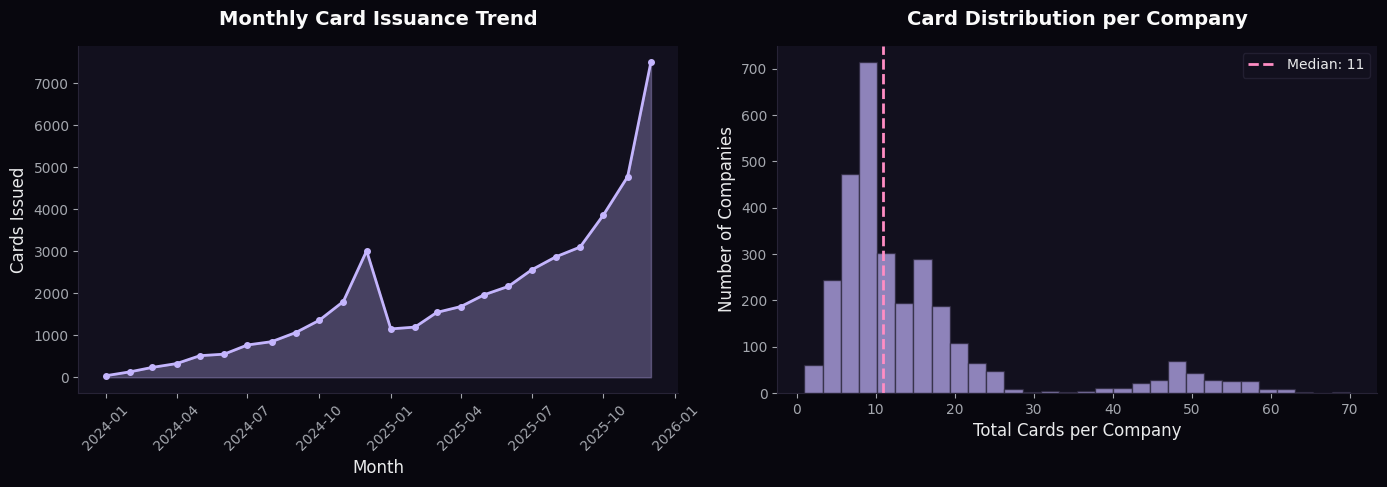

Card Growth Metrics:
  • Avg cards per company: 15.0
  • Median cards per company: 11
  • Avg card growth rate: 2.22 cards/month


In [6]:
# NRR Analysis: Card Growth & Product Expansion
# Convert dates
cards['issue_date'] = pd.to_datetime(cards['issue_date'])
companies['signup_date'] = pd.to_datetime(companies['signup_date'])
product_subs['start_date'] = pd.to_datetime(product_subs['start_date'])

# Calculate card growth over time per company
cards_by_month = (
    cards.merge(companies[['id', 'signup_date', 'size_segment']], left_on='company_id', right_on='id', suffixes=('', '_co'))
    .assign(issue_month=lambda x: x['issue_date'].dt.to_period('M'))
)

# Monthly card issuance trend
monthly_cards = cards_by_month.groupby('issue_month').size().reset_index(name='cards_issued')
monthly_cards['issue_month'] = monthly_cards['issue_month'].dt.to_timestamp()

# Cards per company over time (cumulative)
cards_cumulative = (
    cards_by_month
    .sort_values('issue_date')
    .groupby('company_id')
    .agg(
        first_card=('issue_date', 'min'),
        last_card=('issue_date', 'max'),
        total_cards=('id', 'count')
    )
    .reset_index()
)
cards_cumulative['tenure_days'] = (cards_cumulative['last_card'] - cards_cumulative['first_card']).dt.days
cards_cumulative['cards_per_month'] = cards_cumulative['total_cards'] / (cards_cumulative['tenure_days'] / 30 + 1)

# Plot card issuance trend
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(monthly_cards['issue_month'], monthly_cards['cards_issued'], 
             color=COLORS['primary'], linewidth=2, marker='o', markersize=4)
axes[0].fill_between(monthly_cards['issue_month'], monthly_cards['cards_issued'], alpha=0.3, color=COLORS['primary'])
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Cards Issued')
axes[0].set_title('Monthly Card Issuance Trend', fontweight='bold', pad=15)
axes[0].tick_params(axis='x', rotation=45)

# Distribution of cards per company
axes[1].hist(cards_cumulative['total_cards'], bins=30, color=COLORS['primary'], 
             alpha=0.7, edgecolor='#272336')
axes[1].axvline(cards_cumulative['total_cards'].median(), color=COLORS['secondary'], 
                linestyle='--', linewidth=2, label=f"Median: {cards_cumulative['total_cards'].median():.0f}")
axes[1].set_xlabel('Total Cards per Company')
axes[1].set_ylabel('Number of Companies')
axes[1].set_title('Card Distribution per Company', fontweight='bold', pad=15)
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Card Growth Metrics:")
print(f"  • Avg cards per company: {cards_cumulative['total_cards'].mean():.1f}")
print(f"  • Median cards per company: {cards_cumulative['total_cards'].median():.0f}")
print(f"  • Avg card growth rate: {cards_cumulative['cards_per_month'].mean():.2f} cards/month")

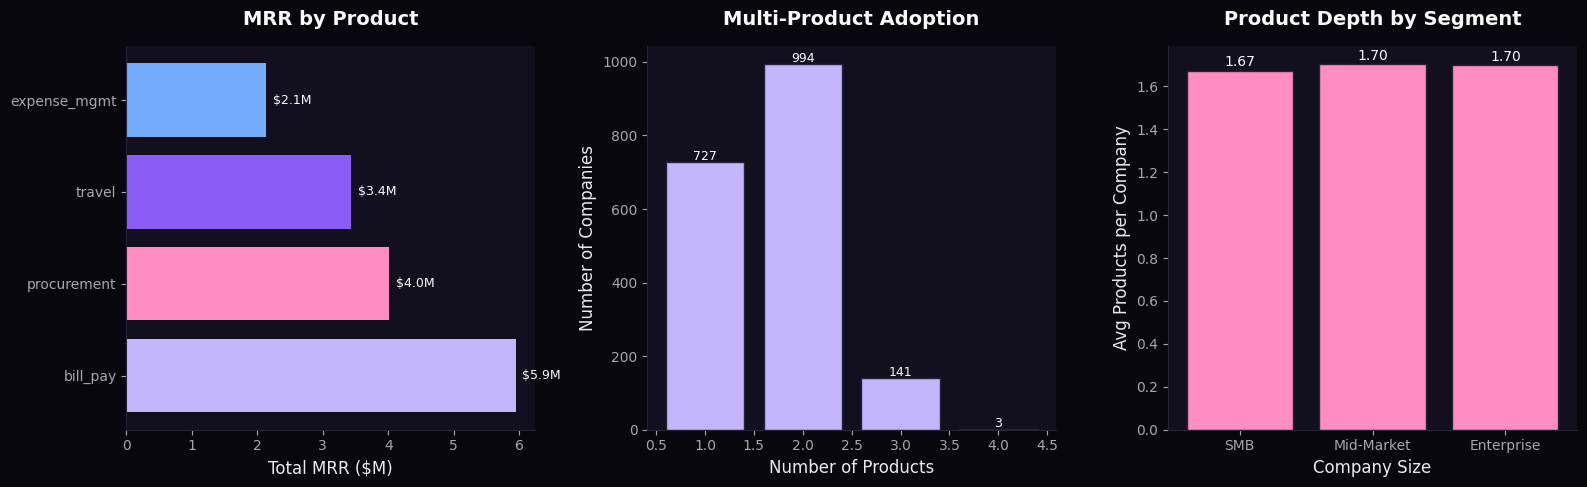


Product Breakdown:
     product  active_subs  total_mrr     avg_mrr
    bill_pay         1404 5947561.72 3525.525619
 procurement         1042 4017935.55 3263.960642
      travel          850 3430507.05 3383.143047
expense_mgmt          469 2136542.96 3761.519296


In [7]:
# Product Expansion Analysis: Which products are customers adding?
# Examine product adoption patterns
product_summary = product_subs.groupby('product').agg(
    total_subs=('id', 'count'),
    active_subs=('status', lambda x: (x == 'active').sum()),
    total_mrr=('mrr_usd', 'sum'),
    avg_mrr=('mrr_usd', 'mean')
).reset_index()
product_summary['active_rate'] = product_summary['active_subs'] / product_summary['total_subs'] * 100
product_summary = product_summary.sort_values('total_mrr', ascending=False)

# Multi-product adoption: how many products per company?
products_per_company = (
    product_subs[product_subs['status'] == 'active']
    .groupby('company_id')
    .agg(
        product_count=('product', 'nunique'),
        total_mrr=('mrr_usd', 'sum'),
        products=('product', lambda x: ', '.join(sorted(x.unique())))
    )
    .reset_index()
)

# Merge with company info
products_per_company = products_per_company.merge(
    companies[['id', 'size_segment', 'signup_date']], 
    left_on='company_id', right_on='id'
)

# Visualize product adoption
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Product MRR breakdown
bars = axes[0].barh(product_summary['product'], product_summary['total_mrr'] / 1e6, 
                    color=CATEGORICAL_PALETTE[:len(product_summary)])
axes[0].set_xlabel('Total MRR (\$M)')
axes[0].set_title('MRR by Product', fontweight='bold', pad=15)
for bar, val in zip(bars, product_summary['total_mrr'] / 1e6):
    axes[0].text(val + 0.1, bar.get_y() + bar.get_height()/2, f'${val:.1f}M', va='center', fontsize=9)

# Multi-product adoption distribution
product_count_dist = products_per_company['product_count'].value_counts().sort_index()
axes[1].bar(product_count_dist.index, product_count_dist.values, color=COLORS['primary'], edgecolor='#272336')
axes[1].set_xlabel('Number of Products')
axes[1].set_ylabel('Number of Companies')
axes[1].set_title('Multi-Product Adoption', fontweight='bold', pad=15)
for i, v in enumerate(product_count_dist.values):
    axes[1].text(product_count_dist.index[i], v + 5, f'{v}', ha='center', fontsize=9)

# Avg products by segment
avg_products_by_segment = products_per_company.groupby('size_segment')['product_count'].mean().reindex(size_order)
axes[2].bar(size_order, avg_products_by_segment.values, color=COLORS['secondary'], edgecolor='#272336')
axes[2].set_xlabel('Company Size')
axes[2].set_ylabel('Avg Products per Company')
axes[2].set_title('Product Depth by Segment', fontweight='bold', pad=15)
for i, v in enumerate(avg_products_by_segment.values):
    axes[2].text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\nProduct Breakdown:")
print(product_summary[['product', 'active_subs', 'total_mrr', 'avg_mrr']].to_string(index=False))

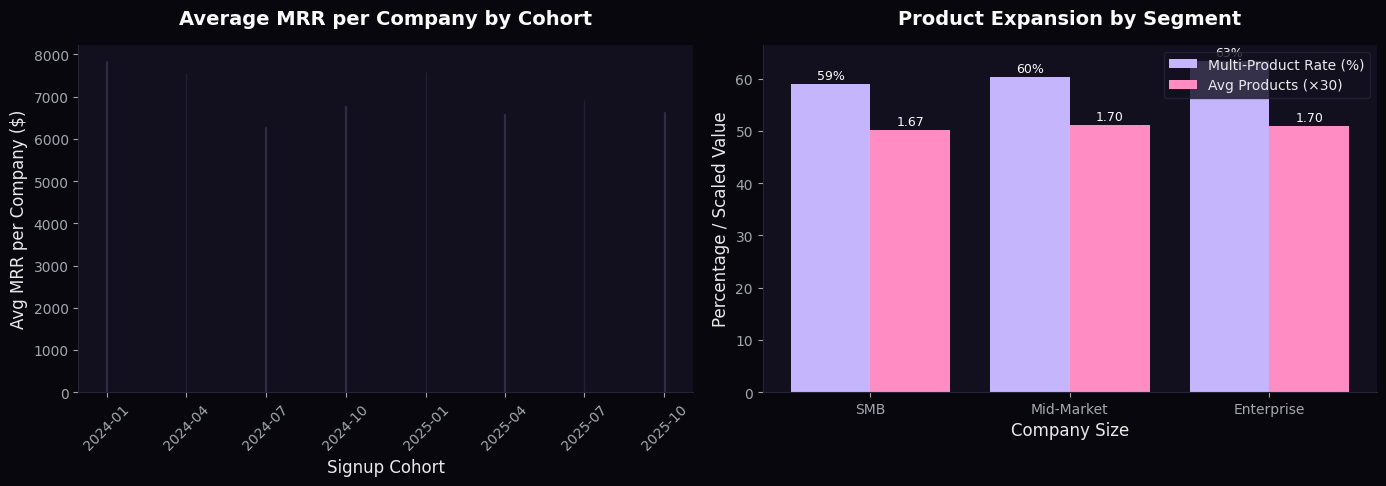

NRR EXPANSION METRICS

📦 CARD EXPANSION:
  • Avg cards per company: 15.0
  • Card growth rate: 2.22 cards/month

🛒 PRODUCT EXPANSION:
  • Companies with 1 product: 727 (39.0%)
  • Companies with 2+ products: 1138 (61.0%)
  • Companies with 3+ products: 144 (7.7%)

📈 MULTI-PRODUCT RATE BY SEGMENT:
  • SMB: 58.9% multi-product, 1.67 avg products
  • Mid-Market: 60.3% multi-product, 1.70 avg products
  • Enterprise: 63.3% multi-product, 1.70 avg products

💵 MRR BY PRODUCT:
  • bill_pay: $5.95M (1,404 active)
  • procurement: $4.02M (1,042 active)
  • travel: $3.43M (850 active)
  • expense_mgmt: $2.14M (469 active)


In [10]:
# NRR Proxy: Calculate expansion metrics by cohort
# Define signup cohorts (quarterly)
companies['signup_quarter'] = companies['signup_date'].dt.to_period('Q')
product_subs['start_quarter'] = product_subs['start_date'].dt.to_period('Q')

# Calculate NRR proxy: compare MRR growth between cohorts
cohort_data = (
    product_subs[product_subs['status'] == 'active']
    .merge(companies[['id', 'signup_quarter']], left_on='company_id', right_on='id')
)
cohort_mrr = (
    cohort_data
    .groupby('signup_quarter')
    .agg(
        companies=('company_id', 'nunique'),
        total_mrr=('mrr_usd', 'sum')
    )
    .reset_index()
)
cohort_mrr['avg_mrr_per_company'] = cohort_mrr['total_mrr'] / cohort_mrr['companies']
cohort_mrr['signup_quarter'] = cohort_mrr['signup_quarter'].dt.to_timestamp()

# Multi-product rate by segment (products_per_company already exists with size_segment)
multi_product_rate = (
    products_per_company
    .groupby('size_segment')
    .agg(
        total_companies=('company_id', 'count'),
        multi_product=('product_count', lambda x: (x > 1).sum()),
        avg_products=('product_count', 'mean'),
        avg_mrr=('total_mrr', 'mean')
    )
    .reindex(size_order)
)
multi_product_rate['multi_product_rate'] = multi_product_rate['multi_product'] / multi_product_rate['total_companies'] * 100

# Create NRR summary visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cohort MRR growth
axes[0].bar(cohort_mrr['signup_quarter'], cohort_mrr['avg_mrr_per_company'], 
            color=COLORS['primary'], edgecolor='#272336', alpha=0.8)
axes[0].set_xlabel('Signup Cohort')
axes[0].set_ylabel('Avg MRR per Company ($)')
axes[0].set_title('Average MRR per Company by Cohort', fontweight='bold', pad=15)
axes[0].tick_params(axis='x', rotation=45)

# Multi-product expansion rate by segment
x = np.arange(len(size_order))
width = 0.4
bars1 = axes[1].bar(x - width/2, multi_product_rate['multi_product_rate'], width, 
                    label='Multi-Product Rate (%)', color=COLORS['primary'])
bars2 = axes[1].bar(x + width/2, multi_product_rate['avg_products'] * 30, width,  # Scale for visibility
                    label='Avg Products (×30)', color=COLORS['secondary'])

axes[1].set_xlabel('Company Size')
axes[1].set_ylabel('Percentage / Scaled Value')
axes[1].set_title('Product Expansion by Segment', fontweight='bold', pad=15)
axes[1].set_xticks(x)
axes[1].set_xticklabels(size_order)
axes[1].legend()

for bar, val in zip(bars1, multi_product_rate['multi_product_rate']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.0f}%', ha='center', fontsize=9)
for bar, val in zip(bars2, multi_product_rate['avg_products']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print NRR Summary
print("=" * 60)
print("NRR EXPANSION METRICS")
print("=" * 60)
print(f"\n📦 CARD EXPANSION:")
print(f"  • Avg cards per company: {cards_cumulative['total_cards'].mean():.1f}")
print(f"  • Card growth rate: {cards_cumulative['cards_per_month'].mean():.2f} cards/month")

print(f"\n🛒 PRODUCT EXPANSION:")
print(f"  • Companies with 1 product: {(products_per_company['product_count'] == 1).sum()} ({(products_per_company['product_count'] == 1).mean()*100:.1f}%)")
print(f"  • Companies with 2+ products: {(products_per_company['product_count'] >= 2).sum()} ({(products_per_company['product_count'] >= 2).mean()*100:.1f}%)")
print(f"  • Companies with 3+ products: {(products_per_company['product_count'] >= 3).sum()} ({(products_per_company['product_count'] >= 3).mean()*100:.1f}%)")

print(f"\n📈 MULTI-PRODUCT RATE BY SEGMENT:")
for seg in size_order:
    rate = multi_product_rate.loc[seg, 'multi_product_rate']
    avg = multi_product_rate.loc[seg, 'avg_products']
    print(f"  • {seg}: {rate:.1f}% multi-product, {avg:.2f} avg products")

print(f"\n💵 MRR BY PRODUCT:")
for _, row in product_summary.iterrows():
    print(f"  • {row['product']}: ${row['total_mrr']/1e6:.2f}M ({row['active_subs']:,} active)")

In [11]:
# Load marketing spend data for CAC analysis
marketing_spend = pd.read_sql("SELECT * FROM marketing_spend", engine)
print(f"Marketing spend data: {len(marketing_spend)} rows")
print(marketing_spend.head(10))
print(f"\nChannels: {marketing_spend['channel'].unique()}")
print(f"Date range: {marketing_spend['month'].min()} to {marketing_spend['month'].max()}")

Marketing spend data: 2400 rows
   id  channel                    campaign       month  spend_usd  \
0   1  organic  organic_campaign_202401_01  2024-01-01     163.44   
1   2  organic  organic_campaign_202401_02  2024-01-01     192.98   
2   3  organic  organic_campaign_202401_03  2024-01-01     622.83   
3   4  organic  organic_campaign_202401_04  2024-01-01      15.15   
4   5  organic  organic_campaign_202401_05  2024-01-01     278.18   
5   6  organic  organic_campaign_202401_06  2024-01-01     290.50   
6   7  organic  organic_campaign_202401_07  2024-01-01     153.87   
7   8  organic  organic_campaign_202401_08  2024-01-01     637.68   
8   9  organic  organic_campaign_202401_09  2024-01-01     195.40   
9  10  organic  organic_campaign_202401_10  2024-01-01      61.60   

   signups_attributed  impressions  
0                   0        40794  
1                   2        82293  
2                   1        19145  
3                   0        46663  
4                   0  

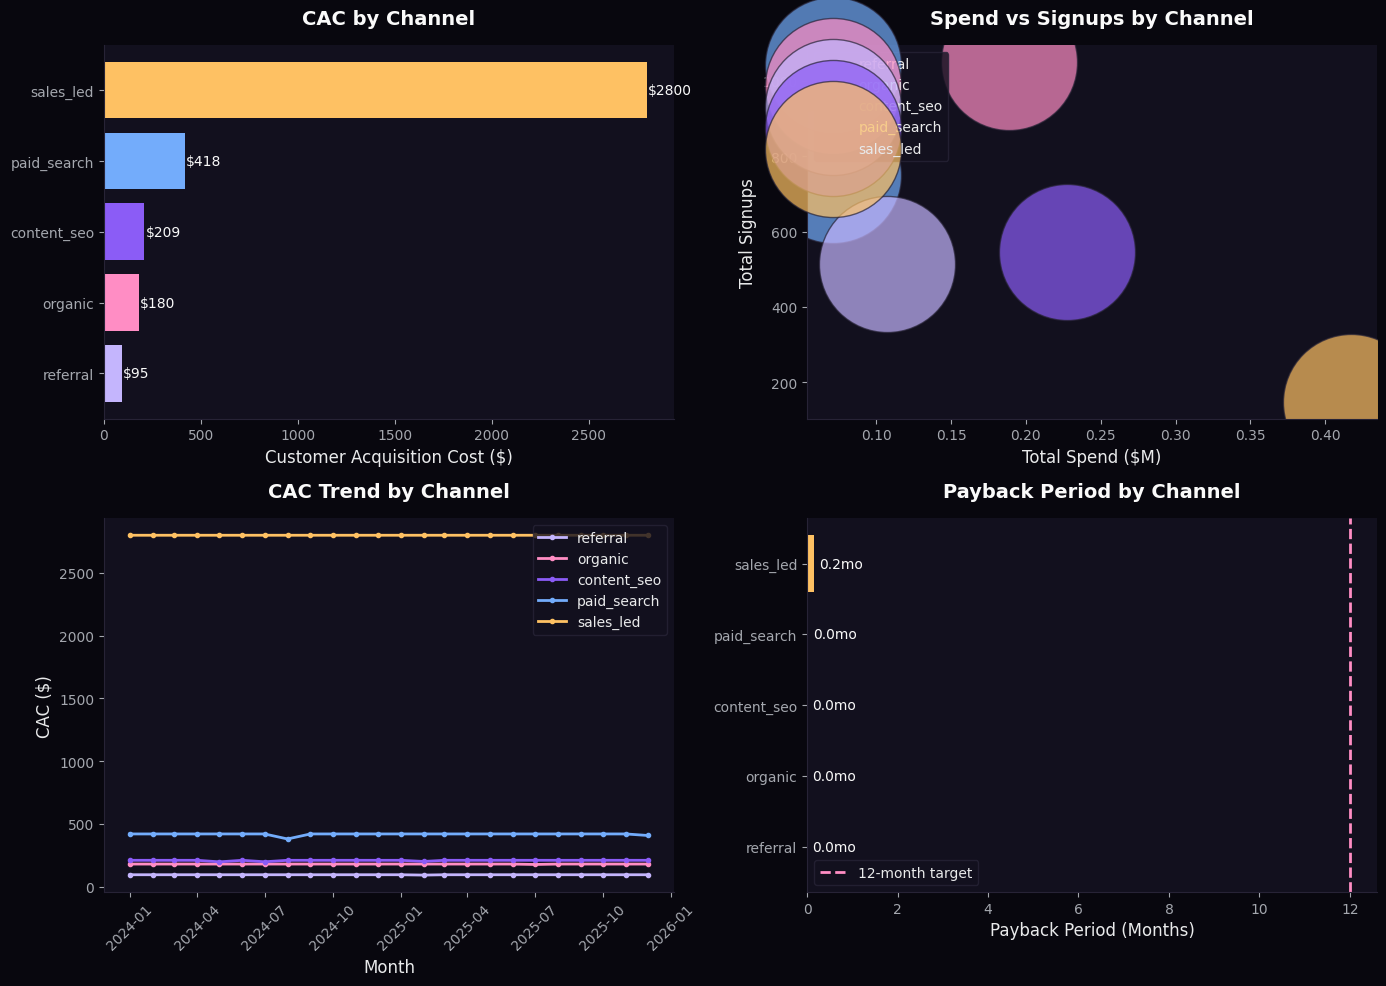

CAC & PAYBACK ANALYSIS

📊 REVENUE ASSUMPTIONS:
  • Avg monthly card spend: $728,329
  • Interchange rate: 1.5%
  • Avg product MRR: $7,027
  • Est. monthly revenue/customer: $17,952

💰 CAC BY CHANNEL:
  • referral: $95 CAC, 0.0mo payback, 750 signups
  • organic: $180 CAC, 0.0mo payback, 1,050 signups
  • content_seo: $209 CAC, 0.0mo payback, 513 signups
  • paid_search: $418 CAC, 0.0mo payback, 545 signups
  • sales_led: $2800 CAC, 0.2mo payback, 149 signups


In [12]:
# CAC Analysis by Channel
marketing_spend['month'] = pd.to_datetime(marketing_spend['month'])

# Aggregate by channel
channel_metrics = (
    marketing_spend
    .groupby('channel')
    .agg(
        total_spend=('spend_usd', 'sum'),
        total_signups=('signups_attributed', 'sum'),
        total_impressions=('impressions', 'sum'),
        campaigns=('campaign', 'nunique')
    )
    .reset_index()
)
channel_metrics['cac'] = channel_metrics['total_spend'] / channel_metrics['total_signups']
channel_metrics['cost_per_impression'] = channel_metrics['total_spend'] / channel_metrics['total_impressions'] * 1000  # CPM
channel_metrics = channel_metrics.sort_values('cac')

# Monthly CAC trends by channel
monthly_cac = (
    marketing_spend
    .groupby(['month', 'channel'])
    .agg(spend=('spend_usd', 'sum'), signups=('signups_attributed', 'sum'))
    .reset_index()
)
monthly_cac['cac'] = monthly_cac['spend'] / monthly_cac['signups'].replace(0, np.nan)

# Calculate payback period: CAC / avg monthly revenue per customer
# Estimate avg monthly revenue per customer from card spend + product MRR
avg_card_spend_per_company = card_spend['total_spend'].mean() / 12  # Annualize to monthly
avg_product_mrr = products_per_company['total_mrr'].mean()
# Assume interchange revenue ~1.5% of card spend
interchange_rate = 0.015
avg_monthly_revenue = (avg_card_spend_per_company * interchange_rate) + avg_product_mrr

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. CAC by Channel (horizontal bar)
bars = axes[0, 0].barh(channel_metrics['channel'], channel_metrics['cac'], 
                        color=CATEGORICAL_PALETTE[:len(channel_metrics)])
axes[0, 0].set_xlabel('Customer Acquisition Cost ($)')
axes[0, 0].set_title('CAC by Channel', fontweight='bold', pad=15)
for bar, val in zip(bars, channel_metrics['cac']):
    axes[0, 0].text(val + 5, bar.get_y() + bar.get_height()/2, f'${val:.0f}', va='center', fontsize=10)

# 2. Signups vs Spend by Channel (bubble chart)
for i, row in channel_metrics.iterrows():
    axes[0, 1].scatter(row['total_spend']/1e6, row['total_signups'], 
                       s=row['campaigns']*20, alpha=0.7,
                       color=CATEGORICAL_PALETTE[i % len(CATEGORICAL_PALETTE)],
                       label=row['channel'], edgecolors='#272336')
axes[0, 1].set_xlabel('Total Spend ($M)')
axes[0, 1].set_ylabel('Total Signups')
axes[0, 1].set_title('Spend vs Signups by Channel', fontweight='bold', pad=15)
axes[0, 1].legend(loc='upper left')

# 3. CAC Trend Over Time
for i, channel in enumerate(channel_metrics['channel']):
    channel_data = monthly_cac[monthly_cac['channel'] == channel]
    axes[1, 0].plot(channel_data['month'], channel_data['cac'], 
                    label=channel, color=CATEGORICAL_PALETTE[i], linewidth=2, marker='o', markersize=3)
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('CAC ($)')
axes[1, 0].set_title('CAC Trend by Channel', fontweight='bold', pad=15)
axes[1, 0].legend(loc='upper right')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Payback Period by Channel
channel_metrics['payback_months'] = channel_metrics['cac'] / avg_monthly_revenue
bars = axes[1, 1].barh(channel_metrics['channel'], channel_metrics['payback_months'],
                        color=CATEGORICAL_PALETTE[:len(channel_metrics)])
axes[1, 1].axvline(x=12, color=COLORS['secondary'], linestyle='--', linewidth=2, label='12-month target')
axes[1, 1].set_xlabel('Payback Period (Months)')
axes[1, 1].set_title('Payback Period by Channel', fontweight='bold', pad=15)
axes[1, 1].legend()
for bar, val in zip(bars, channel_metrics['payback_months']):
    axes[1, 1].text(val + 0.1, bar.get_y() + bar.get_height()/2, f'{val:.1f}mo', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Summary stats
print("=" * 60)
print("CAC & PAYBACK ANALYSIS")
print("=" * 60)
print(f"\n📊 REVENUE ASSUMPTIONS:")
print(f"  • Avg monthly card spend: ${avg_card_spend_per_company:,.0f}")
print(f"  • Interchange rate: {interchange_rate*100:.1f}%")
print(f"  • Avg product MRR: ${avg_product_mrr:,.0f}")
print(f"  • Est. monthly revenue/customer: ${avg_monthly_revenue:,.0f}")

print(f"\n💰 CAC BY CHANNEL:")
for _, row in channel_metrics.iterrows():
    print(f"  • {row['channel']}: ${row['cac']:.0f} CAC, {row['payback_months']:.1f}mo payback, {row['total_signups']:,} signups")

In [13]:
# Load AI queries data for Ramp Research analysis
ai_queries = pd.read_sql("SELECT * FROM ai_queries", engine)
ai_queries['query_at'] = pd.to_datetime(ai_queries['query_at'])

print(f"AI Queries data: {len(ai_queries):,} rows")
print(f"\nQuery types: {ai_queries['query_type'].unique()}")
print(f"Resolutions: {ai_queries['resolution'].unique()}")
print(f"Statuses: {ai_queries['status'].unique()}")
print(f"Date range: {ai_queries['query_at'].min().date()} to {ai_queries['query_at'].max().date()}")
print(f"\nSample data:")
print(ai_queries.head())

AI Queries data: 25,000 rows

Query types: ['budget_variance' 'spend_analysis' 'vendor_comparison' 'policy_check'
 'other']
Resolutions: ['auto_resolved' 'human_resolved' 'escalated' 'incomplete']
Statuses: ['completed' 'incomplete']
Date range: 2025-01-01 to 2025-12-30

Sample data:
   id  company_id         query_type      resolution            query_at  \
0   1         196    budget_variance   auto_resolved 2025-01-16 10:42:17   
1   2         334     spend_analysis  human_resolved 2025-03-22 02:33:56   
2   3         511  vendor_comparison  human_resolved 2025-02-20 12:46:56   
3   4         304     spend_analysis  human_resolved 2025-02-03 09:51:20   
4   5         916     spend_analysis   auto_resolved 2025-03-11 03:18:11   

   response_time_sec     status  
0                2.6  completed  
1              157.1  completed  
2              178.4  completed  
3              549.8  completed  
4                4.2  completed  


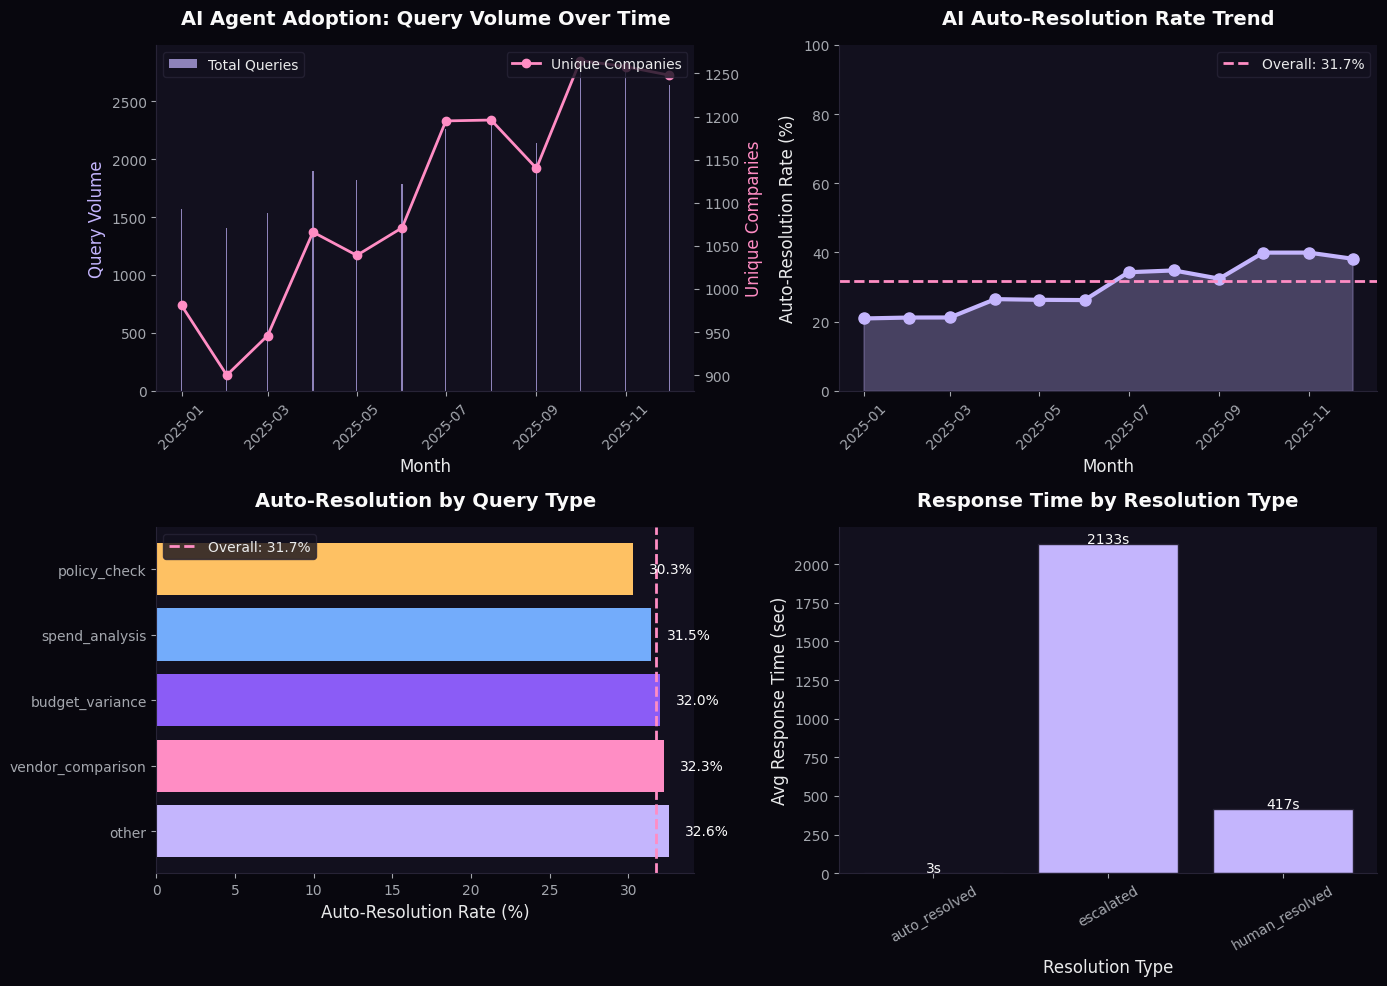

RAMP RESEARCH AI AGENT METRICS

📊 OVERALL STATS:
  • Total queries: 25,000
  • Companies using AI: 1,500
  • Auto-resolution rate: 31.7%

⚡ RESPONSE TIME:
  • Auto-resolved: 3.4 sec avg
  • Human-resolved: 417.4 sec avg
  • Speed improvement: 123x faster with AI

📈 RESOLUTION BY QUERY TYPE:
  • other: 32.6% auto-resolved (1,231 queries)
  • vendor_comparison: 32.3% auto-resolved (4,480 queries)
  • budget_variance: 32.0% auto-resolved (7,035 queries)
  • spend_analysis: 31.5% auto-resolved (10,539 queries)
  • policy_check: 30.3% auto-resolved (1,715 queries)

📅 TREND:
  • Query volume growth: +69% (1,567 → 2,642)
  • Auto-resolve rate change: +17.3pp (20.9% → 38.2%)


In [14]:
# Ramp Research AI Agent Analysis
ai_queries['query_month'] = ai_queries['query_at'].dt.to_period('M').dt.to_timestamp()
ai_queries['query_week'] = ai_queries['query_at'].dt.to_period('W').dt.to_timestamp()

# Overall resolution stats
resolution_stats = ai_queries['resolution'].value_counts()
auto_resolve_rate = (ai_queries['resolution'] == 'auto_resolved').mean() * 100

# Monthly adoption trend (query volume)
monthly_queries = ai_queries.groupby('query_month').agg(
    total_queries=('id', 'count'),
    auto_resolved=('resolution', lambda x: (x == 'auto_resolved').sum()),
    unique_companies=('company_id', 'nunique'),
    avg_response_time=('response_time_sec', 'mean')
).reset_index()
monthly_queries['auto_resolve_rate'] = monthly_queries['auto_resolved'] / monthly_queries['total_queries'] * 100

# Resolution by query type
resolution_by_type = ai_queries.groupby('query_type').agg(
    total=('id', 'count'),
    auto_resolved=('resolution', lambda x: (x == 'auto_resolved').sum()),
    avg_response_time=('response_time_sec', 'mean')
).reset_index()
resolution_by_type['auto_resolve_rate'] = resolution_by_type['auto_resolved'] / resolution_by_type['total'] * 100
resolution_by_type = resolution_by_type.sort_values('auto_resolve_rate', ascending=False)

# Response time by resolution type
response_by_resolution = ai_queries.groupby('resolution')['response_time_sec'].agg(['mean', 'median', 'count']).reset_index()

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Monthly Query Volume & Adoption
ax1 = axes[0, 0]
ax1.bar(monthly_queries['query_month'], monthly_queries['total_queries'], 
        color=COLORS['primary'], alpha=0.7, label='Total Queries')
ax1.set_xlabel('Month')
ax1.set_ylabel('Query Volume', color=COLORS['primary'])
ax1.tick_params(axis='x', rotation=45)
ax1.set_title('AI Agent Adoption: Query Volume Over Time', fontweight='bold', pad=15)

ax1b = ax1.twinx()
ax1b.plot(monthly_queries['query_month'], monthly_queries['unique_companies'], 
          color=COLORS['secondary'], linewidth=2, marker='o', label='Unique Companies')
ax1b.set_ylabel('Unique Companies', color=COLORS['secondary'])
ax1.legend(loc='upper left')
ax1b.legend(loc='upper right')

# 2. Auto-Resolution Rate Trend
axes[0, 1].plot(monthly_queries['query_month'], monthly_queries['auto_resolve_rate'], 
                color=COLORS['primary'], linewidth=3, marker='o', markersize=8)
axes[0, 1].axhline(y=auto_resolve_rate, color=COLORS['secondary'], linestyle='--', 
                   linewidth=2, label=f'Overall: {auto_resolve_rate:.1f}%')
axes[0, 1].fill_between(monthly_queries['query_month'], monthly_queries['auto_resolve_rate'], 
                        alpha=0.3, color=COLORS['primary'])
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Auto-Resolution Rate (%)')
axes[0, 1].set_title('AI Auto-Resolution Rate Trend', fontweight='bold', pad=15)
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_ylim(0, 100)

# 3. Resolution Rate by Query Type
bars = axes[1, 0].barh(resolution_by_type['query_type'], resolution_by_type['auto_resolve_rate'],
                        color=CATEGORICAL_PALETTE[:len(resolution_by_type)])
axes[1, 0].axvline(x=auto_resolve_rate, color=COLORS['secondary'], linestyle='--', 
                   linewidth=2, label=f'Overall: {auto_resolve_rate:.1f}%')
axes[1, 0].set_xlabel('Auto-Resolution Rate (%)')
axes[1, 0].set_title('Auto-Resolution by Query Type', fontweight='bold', pad=15)
axes[1, 0].legend()
for bar, val in zip(bars, resolution_by_type['auto_resolve_rate']):
    axes[1, 0].text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', va='center', fontsize=10)

# 4. Response Time by Resolution Type
colors_res = [COLORS['green'] if r == 'auto_resolved' else COLORS['primary'] 
              for r in response_by_resolution['resolution']]
bars = axes[1, 1].bar(response_by_resolution['resolution'], response_by_resolution['mean'],
                      color=colors_res, edgecolor='#272336')
axes[1, 1].set_xlabel('Resolution Type')
axes[1, 1].set_ylabel('Avg Response Time (sec)')
axes[1, 1].set_title('Response Time by Resolution Type', fontweight='bold', pad=15)
axes[1, 1].tick_params(axis='x', rotation=30)
for bar, val in zip(bars, response_by_resolution['mean']):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, val + 5, f'{val:.0f}s', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Print Summary
print("=" * 60)
print("RAMP RESEARCH AI AGENT METRICS")
print("=" * 60)
print(f"\n📊 OVERALL STATS:")
print(f"  • Total queries: {len(ai_queries):,}")
print(f"  • Companies using AI: {ai_queries['company_id'].nunique():,}")
print(f"  • Auto-resolution rate: {auto_resolve_rate:.1f}%")

print(f"\n⚡ RESPONSE TIME:")
auto_time = ai_queries[ai_queries['resolution'] == 'auto_resolved']['response_time_sec'].mean()
human_time = ai_queries[ai_queries['resolution'] == 'human_resolved']['response_time_sec'].mean()
print(f"  • Auto-resolved: {auto_time:.1f} sec avg")
print(f"  • Human-resolved: {human_time:.1f} sec avg")
print(f"  • Speed improvement: {human_time/auto_time:.0f}x faster with AI")

print(f"\n📈 RESOLUTION BY QUERY TYPE:")
for _, row in resolution_by_type.iterrows():
    print(f"  • {row['query_type']}: {row['auto_resolve_rate']:.1f}% auto-resolved ({row['total']:,} queries)")

print(f"\n📅 TREND:")
first_month = monthly_queries.iloc[0]
last_month = monthly_queries.iloc[-1]
volume_growth = (last_month['total_queries'] / first_month['total_queries'] - 1) * 100
rate_change = last_month['auto_resolve_rate'] - first_month['auto_resolve_rate']
print(f"  • Query volume growth: {volume_growth:+.0f}% ({first_month['total_queries']:,} → {last_month['total_queries']:,})")
print(f"  • Auto-resolve rate change: {rate_change:+.1f}pp ({first_month['auto_resolve_rate']:.1f}% → {last_month['auto_resolve_rate']:.1f}%)")